In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

In [4]:
E_list_uterus = np.load('data/E_list_uterus.npy')

Fp_list_uterus = np.load('data/Fp_list_uterus.npy')

vp_list_uterus = np.load('data/vp_list_uterus.npy')



array([4.38512085e-02, 0.00000000e+00, 1.68928530e-01, 1.02423649e-01,
       1.39036270e-01, 1.36740597e-01, 8.06717497e-02, 1.95099205e-01,
       0.00000000e+00, 1.34267907e-02, 9.74253943e-02, 0.00000000e+00,
       8.24417098e-02, 1.51790270e-01, 1.46028359e-01, 1.14178520e-01,
       7.70471000e-02, 5.80831042e-02, 2.13124521e-01, 3.48362205e-02,
       1.16599641e-01, 1.98062357e-01, 8.54829114e-02, 7.37665656e-02,
       1.08204696e-01, 1.30734945e-01, 1.74037038e-01, 8.32117793e-02,
       3.06435945e-02, 1.02497656e-01, 1.94899598e-01, 2.15077964e-01,
       1.13474960e-01, 1.24314733e-01, 1.39362960e-01, 1.34560552e-01,
       1.06996692e-01, 7.07717682e-02, 3.99746851e-02, 9.50135683e-02,
       7.73546368e-02, 8.75016363e-03, 4.96885382e-02, 2.05292887e-01,
       2.60073466e-01, 2.45321344e-01, 0.00000000e+00, 4.58184291e-02,
       9.50508920e-02, 1.07670257e-01, 6.47055368e-02, 1.21688002e-01,
       2.41464337e-01, 2.11682213e-01, 0.00000000e+00, 4.11390544e-01,
      

In [25]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "halfnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [46]:
best_dist, best_p, params = get_best_distribution(E_list_uterus)



p value for norm = 4.4280421604418845e-07
p value for exponweib = 5.068186581424961e-43
p value for weibull_max = 1.8908203983161802e-05
p value for weibull_min = 1.1976566436805731e-11
p value for pareto = 9.994804397938391e-29
p value for genextreme = 1.883160947680226e-05
p value for halfnorm = 2.2656548070344783e-08
Best fitting distribution: weibull_max
Best p value: 1.8908203983161802e-05
Parameters for the best fit: (7688.847480902937, 611.301464541747, 611.2105306280209)


/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


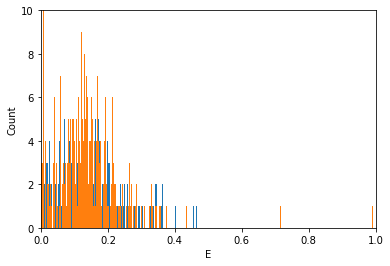

<Figure size 432x288 with 0 Axes>

In [50]:

c, loc, scale =  params
gen_data = st.weibull_max.rvs(c, loc, scale, size=E_list_uterus.shape[0])

plt.hist(gen_data, bins = 1000, label='generated')
plt.hist(E_list_uterus, bins = 1000, label = 'true')
plt.xlabel('E')
plt.ylabel('Count')
plt.xlim(0,1)
plt.ylim(0,10)

plt.show()
plt.clf()

In [51]:
best_dist, best_p, params = get_best_distribution(Fp_list_uterus)



p value for norm = 6.171379944303095e-19


/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:1468: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 2.3017200714191543e-176
p value for weibull_max = 6.419464277436174e-06
p value for weibull_min = 4.5647456059989e-310
p value for pareto = 0.02821089826641951
p value for genextreme = 0.02254684248589588
p value for halfnorm = 3.439194826985523e-12
Best fitting distribution: pareto
Best p value: 0.02821089826641951
Parameters for the best fit: (3.8227816780555406, -0.02062317879656861, 0.020623278140069902)


905 905


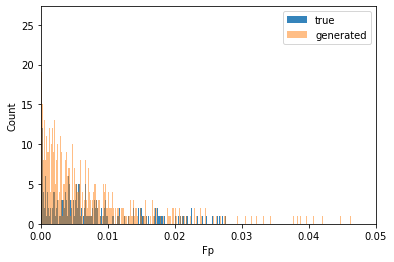

<Figure size 432x288 with 0 Axes>

In [57]:

c, loc, scale =  params
gen_dataFp = st.pareto.rvs(c, loc, scale, size=Fp_list_uterus.shape[0])
print(gen_data.size, Fp_list_uterus.size)
plt.hist(Fp_list_uterus, alpha = 0.9, bins = 1000, label = 'true')
plt.hist(gen_dataFp, bins = 1000, alpha=0.5, label='generated')
plt.legend(loc='upper right')
plt.xlim(0,0.05)
plt.xlabel('Fp')
plt.ylabel('Count')



plt.show()
plt.clf()



In [68]:
vp_list_uterus_noend = vp_list_uterus[vp_list_uterus <= 0.97]
print(vp_list_uterus_noend.size)
best_dist, best_p, params = get_best_distribution(vp_list_uterus_noend)


645
p value for norm = 1.6611684693371523e-07
p value for exponweib = 1.0973250724938875e-97
p value for weibull_max = 0.0010547123332707664
p value for weibull_min = 3.6948179644828657e-06
p value for pareto = 2.983862928670769e-06
p value for genextreme = 0.0004979011042653114
p value for halfnorm = 1.4598328582009634e-07
Best fitting distribution: weibull_max
Best p value: 0.0010547123332707664
Parameters for the best fit: (29572479.030125827, 6450136.935704315, 6450136.715197781)


(905,)


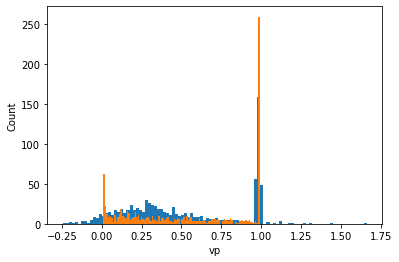

<Figure size 432x288 with 0 Axes>

In [77]:
def vp_distrubition(num):
    params = (29572479.030125827, 6450136.935704315, 6450136.715197781)
    p = 0.287
    endnum = int(p*num)
    end = np.random.uniform(low = 0.97, high= 1.0, size = endnum)
    
    dist_num = num - endnum
    gen_data_vp = st.weibull_max.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_vp = np.array(gen_data_vp)
    
    true_dist = np.concatenate((gen_data_vp, end), axis=None)
    print(true_dist.shape)
    
    
    return true_dist




true_dist = vp_distrubition(vp_list_uterus.size)

plt.hist(true_dist, bins = 100, )
plt.hist(vp_list_uterus, bins = 100)
plt.xlabel('vp')
plt.ylabel('Count')
plt.show()
plt.clf()